## <center> Credit Risk Modelling - IFRS9 and CECL: Developing Scorecards (Generalized Linear Models)
#### <br> <center> @by Donald Kpatcha

In [1]:
## Uncomment to install it
#! pip uninstall scorecardpy
#or for the latest version via
#! pip install git+git://github.com/shichenxie/scorecardpy.git

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import statsmodels.api as sm
import scorecardpy as sc
#from scorecardpy import woebin, scorecard, scorecard_ply, woebin_ply, woebin_adj
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold


### $ \bf \text{Import data}$

In [3]:

# Import data (data will be provided with this code)
df0 = pd.read_csv('data/Chap2/chap2oneypdcsv.csv', header=0, sep='"",""|,"|,|",|"""|,""|"",|","',\
                  engine='python').replace('"', '', regex=True).iloc[:, 1:45]

# Data overview: data content and format
print(df0.info())
df0.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25906 entries, 0 to 25905
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             25906 non-null  int64  
 1   vintage_year                   25906 non-null  int64  
 2   monthly_installment            25906 non-null  float64
 3   loan_balance                   25906 non-null  float64
 4   bureau_score                   25473 non-null  float64
 5   num_bankrupt_iva               25473 non-null  float64
 6   time_since_bankrupt            25473 non-null  float64
 7   num_ccj                        25473 non-null  float64
 8   time_since_ccj                 25473 non-null  float64
 9   ccj_amount                     25473 non-null  float64
 10  num_bankrupt                   25473 non-null  float64
 11  num_iva                        25473 non-null  float64
 12  min_months_since_bankrupt      25473 non-null 

,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,...,months_since_2mia,avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m,cc_util,annual_income,emp_length,months_since_recent_cc_delinq
0,6670001,2005,746.70,131304.44,541.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,-42.0,0.0,132080.0,542.0,0.4578,76749,3,11
1,9131199,2006,887.40,115486.51,441.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,116972.0,494.0,0.6299,78451,10,7
2,4963167,2004,1008.50,128381.73,282.0,0.0,0.0,1.0,36.0,459.0,...,0.0,0.0,1198.0,2.0,128500.0,290.0,0.6331,31038,3,6
3,3918582,2005,458.23,35482.96,461.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,-114.0,0.0,36610.0,460.0,0.4990,56663,8,6
4,5949777,2006,431.20,77086.31,466.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,77518.0,468.0,0.9568,77014,10,3


### $ \bf \text{Make EDA on the imported data} $

In [4]:
# check/count for missing / NAN data
NAN = (df0.isna().sum()/len(df0)).sort_values(ascending=False)*100
NAN[NAN>0]

recent_arrears_date          96.857871
months_since_2mia            96.857871
num_ccj                       1.671427
min_months_since_bankrupt     1.671427
num_bankrupt                  1.671427
ccj_amount                    1.671427
time_since_ccj                1.671427
num_iva                       1.671427
time_since_bankrupt           1.671427
num_bankrupt_iva              1.671427
bureau_score                  1.671427
avg_bureau_score_6m           1.509303
avg_bal_6m                    0.015440
max_mia_6m                    0.015440
max_arrears_bal_6m            0.015440
avg_mia_6m                    0.015440
region                        0.003860
dtype: float64

##### Note:
'recent_arrears_date', and 'months_since_2mia' columns each contain about 96.85% of NaN/missing enteries, Thus the two colomns will be dropped. Also, given that we have suficient amount of data, we will drop all rows containing NaNs.
           

In [5]:
## drop recent_arrears_date', and 'months_since_2mia' columns columns and store in new dataframe
df = df0.drop(['recent_arrears_date', 'months_since_2mia'], axis=1)

# drop NaNs and duplicates 
df.dropna(inplace=True)

# Date format for relevant date type columns: "origination_date", "maturity_date"
df[["origination_date", "maturity_date"]] = \
                       df[["origination_date", "maturity_date"]].apply(pd.to_datetime)

# change dtype for columns
df[["months_since_recent_cc_delinq"]] = df[["months_since_recent_cc_delinq"]].astype('int')


In [6]:
# Have a look at unique values from object type columns
for col in df.select_dtypes(include=['object']):
    print(col, ":" , df[col].unique())


region : ['r_a' 'r_b' 'r_c' 'r_d' 'r_e' 'r_f' 'r_h' 'r_i' 'r_g' 'r_l' 'r_m']
repayment_type : ['Non-IO' 'IO']


In [7]:
# For later purpose, we replace 'Non-IO' by 0, and 'IO'by 1 in the 'repayment_type' column
df = df.drop_duplicates().replace({'Non-IO': 0, 'IO':1})
df.head(5)


,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,...,max_arrears_12m,avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m,cc_util,annual_income,emp_length,months_since_recent_cc_delinq
0,6670001,2005,746.70,131304.44,541.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,-42.0,0.0,132080.0,542.0,0.4578,76749,3,11
1,9131199,2006,887.40,115486.51,441.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,116972.0,494.0,0.6299,78451,10,7
2,4963167,2004,1008.50,128381.73,282.0,0.0,0.0,1.0,36.0,459.0,...,2.18823,0.0,1198.0,2.0,128500.0,290.0,0.6331,31038,3,6
3,3918582,2005,458.23,35482.96,461.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,-114.0,0.0,36610.0,460.0,0.4990,56663,8,6
4,5949777,2006,431.20,77086.31,466.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,77518.0,468.0,0.9568,77014,10,3


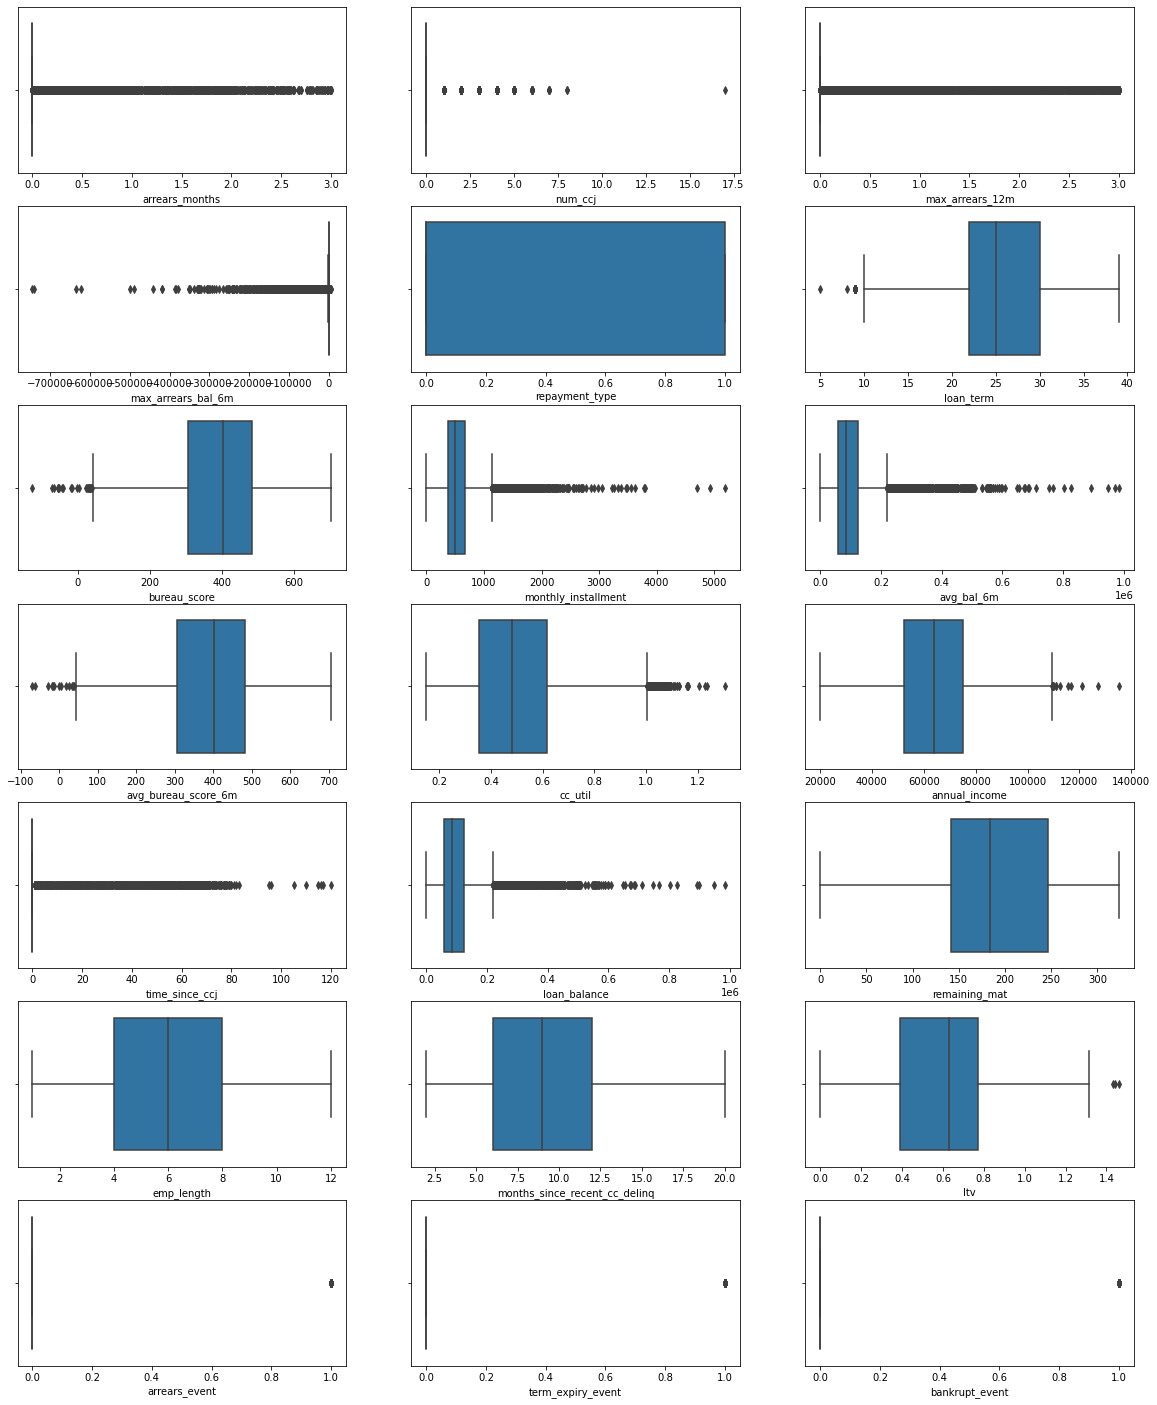

In [8]:

# Plots: search for potential outliers
# In this work, we will make our analysis besed on the following features (columns)
colssel = ['arrears_months', 'num_ccj', 'max_arrears_12m', 'max_arrears_bal_6m', 'repayment_type', 'loan_term',
       'bureau_score', 'monthly_installment', 'avg_bal_6m', 'avg_bureau_score_6m', 'cc_util', 'annual_income',
       'time_since_ccj', 'loan_balance', 'remaining_mat', 'emp_length', 'months_since_recent_cc_delinq','ltv',
       'arrears_event', 'term_expiry_event', 'bankrupt_event']

# Visualizing data
fig, ax = plt.subplots(int(len(colssel)/3), 3, figsize=(20, 25))
key = 0
ix = 0
for val in colssel: 
    if (key/3 == int(key/3)):
        ix = 0

    # plot
    sns.boxplot(x=df[val], ax= ax[int(key/3), ix])
    ix += 1
    key += 1 


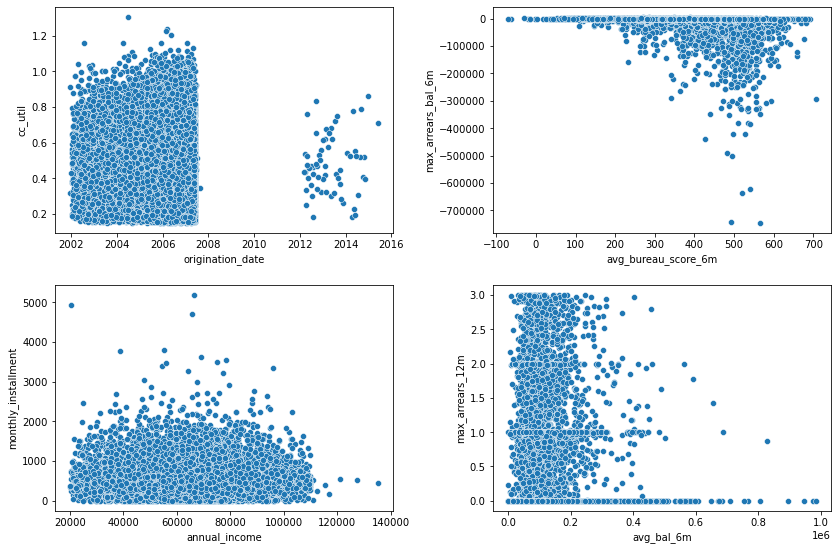

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
ypd = df[df["origination_date"] <= '2018-12-31']
sns.scatterplot(data=ypd, x ="origination_date", y ='cc_util', ax=ax[0,0])
sns.scatterplot(data=ypd, x="avg_bureau_score_6m", y='max_arrears_bal_6m', ax=ax[0,1])
sns.scatterplot(data=ypd, x="annual_income", y='monthly_installment', ax=ax[1,0])
sns.scatterplot(data=ypd, x="avg_bal_6m", y='max_arrears_12m', ax=ax[1,1])
plt.tight_layout(pad=2)
plt.show()


#### Note:

After a close look, it is worth remarking that there is less significant data availabe from, roughly, the year 2008, representing only  about 0.25\% of the total data. Thus, one would be reasonable to consider only the data before 2008, precisely before 2007-08-17.

In [10]:
### Remove outliers
df2 = df.loc[(df["origination_date"] <= '2007-08-17')].copy()

# Round arrears count fields
df2.loc[:,'max_arrears_12m'] = df2['max_arrears_12m'].round(4)
df2.loc[:,'arrears_months'] = df2['arrears_months'].round(4)

# Select columns of interest
colssel = ['arrears_months', 'num_ccj', 'max_arrears_12m', 'max_arrears_bal_6m', 'repayment_type', 'loan_term',
       'bureau_score', 'monthly_installment', 'avg_bal_6m', 'avg_bureau_score_6m', 'cc_util', 'annual_income',
       'time_since_ccj', 'loan_balance', 'remaining_mat', 'emp_length', 'months_since_recent_cc_delinq','ltv',
       'arrears_event', 'term_expiry_event', 'bankrupt_event']

oneypd = df2[colssel].copy()
print(oneypd.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25465 entries, 0 to 25905
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   arrears_months                 25465 non-null  float64
 1   num_ccj                        25465 non-null  float64
 2   max_arrears_12m                25465 non-null  float64
 3   max_arrears_bal_6m             25465 non-null  float64
 4   repayment_type                 25465 non-null  int64  
 5   loan_term                      25465 non-null  int64  
 6   bureau_score                   25465 non-null  float64
 7   monthly_installment            25465 non-null  float64
 8   avg_bal_6m                     25465 non-null  float64
 9   avg_bureau_score_6m            25465 non-null  float64
 10  cc_util                        25465 non-null  float64
 11  annual_income                  25465 non-null  int64  
 12  time_since_ccj                 25465 non-null 

### $ \bf \text{Default flag definition}$


This step allows to define criteria or conditions for default. From a modelling perspective, a default flag is defined as binary variable. It conventionally assumes the value 0 if no default occurs, and 1 in the case of default.
Following Basel II principles “A default is considered to have occurred when: the banking institution considers that an obligor is unlikely to repay in full its credit obligations to the banking group, without recourse by the banking institution to actions such as realising security; or the obligor has breached its contractual repayment schedule and is past due for more than 90 days on any material credit obligation to the banking group”.
From an IFRS9 perspective, it does not directly define default, but requires entities to align with internal credit
risk management. A rebuttable presumption holds: default does not occur later than a financial asset is 90 days
past due.


In the following, the default flag relies on: arrears, bankruptcy and term expiry. Default is
caused when arrears exceed 3 months (that is, 3 months in arrears (MIA) or 90 days past due).
Also, a default flag is triggered when bankruptcy takes place. Moreover, term expiry
indicates that a facility passed its original maturity with a positive residual debt.

In [11]:

# Default flag definition
oneypd.loc[:, 'default_event'] = oneypd.apply(lambda row: 1 if row['arrears_event'] == 1 \
                                             or row['term_expiry_event'] == 1 \
                                             or row['bankrupt_event'] == 1 else 0, axis=1)

# Database split in train and test samples
# Recode default event variables for more convenient use: 0-default, 1-non-default
oneypd.loc[:, 'default_flag'] = oneypd['default_event'].apply(lambda x: 0 if x == 1 else 1)


### $ \bf \text{Splitting data into train and test sets}$

In [12]:
## Splitting data into train and test sets
#train, test = train_test_split(oneypd, test_size=0.3, random_state=42)

# Perform a stratified sampling: 70% train and 30% test
train, test = train_test_split(oneypd, test_size=0.3, stratify=oneypd['default_event'], random_state=2122)


### $ \bf \text{Univariate analysis: Information Value (IV) assessment}$

In [13]:
# Binning and assignment of Weight of Evidence (WOE) values

woe_vars_train = pd.DataFrame()
woe_vars_test = pd.DataFrame()

# Bureau score
woe_vars_train['woe_bureau_score'] = pd.cut(train['bureau_score'], 
                                   bins=[-np.inf, 308, 404, 483, np.inf],
                                   labels=[-0.7994, -0.0545, 0.7722, 1.0375],
                                   right=False, include_lowest=True).replace(np.nan, -0.0910)

woe_vars_test['woe_bureau_score'] = pd.cut(test['bureau_score'], 
                                  bins=[float('-inf'), 308, 404, 483, float('inf')],
                                  labels=[-0.7994, -0.0545, 0.7722, 1.0375],
                                  right=False, include_lowest=True).replace(np.nan, -0.0910)

# CC utilization
woe_vars_train['woe_cc_util'] = pd.cut(train['cc_util'], 
                               bins=[float('-inf'), 0.55, 0.70, 0.85, float('inf')],
                               labels=[1.8323, -0.4867, -1.1623, -2.3562],
                               right=False, include_lowest=True).replace(np.nan, 0)

woe_vars_test['woe_cc_util'] = pd.cut(test['cc_util'], 
                              bins=[float('-inf'), 0.55, 0.70, 0.85, float('inf')],
                              labels=[1.8323, -0.4867, -1.1623, -2.3562],
                              right=False, include_lowest=True).replace(np.nan, 0)

# Number of CCJ events
woe_vars_train['woe_num_ccj'] = pd.cut(train['num_ccj'], 
                               bins=[float('-inf'), 0, 1, float('inf')],
                               labels=[0.1877, -0.9166, -1.1322],
                               right=False, include_lowest=True).replace(np.nan, -0.0910)

woe_vars_test['woe_num_ccj'] = pd.cut(test['num_ccj'], 
                              bins=[float('-inf'), 0, 1, float('inf')],
                              labels=[0.1877, -0.9166, -1.1322],
                              right=False, include_lowest=True).replace(np.nan, -0.0910)

# Maximum arrears in previous 12 months
woe_vars_train['woe_max_arrears_12m'] = pd.cut(train['max_arrears_12m'], 
                                       bins=[float('-inf'), 0, 1, 1.4, float('inf')],
                                       labels=[0.7027, -0.8291, -1.1908, -2.2223],
                                       right=False, include_lowest=True).replace(np.nan, 0)

woe_vars_test['woe_max_arrears_12m'] = pd.cut(test['max_arrears_12m'], 
                                      bins=[float('-inf'), 0, 1, 1.4, float('inf')],
                                      labels=[0.7027, -0.8291, -1.1908, -2.2223],
                                      right=False, include_lowest=True).replace(np.nan, 0)

# Maximum arrears balance in previous 6 months
woe_vars_train['woe_max_arrears_bal_6m'] = pd.cut(train['max_arrears_bal_6m'], 
                                          bins=[float('-inf'), 0, 300, 600, 900, float('inf')],
                                          labels=[0.5771, -0.7818, -1.2958, -1.5753, -2.2110],
                                          right=False, include_lowest=True).replace(np.nan, 0)

woe_vars_test['woe_max_arrears_bal_6m'] = pd.cut(test['max_arrears_bal_6m'], 
                                         bins=[float('-inf'), 0, 300, 600, 900, float('inf')],
                                         labels=[0.5771, -0.7818, -1.2958, -1.5753, -2.2110],
                                         right=False, include_lowest=True).replace(np.nan, 0)

# Employment length (years)
woe_vars_train['woe_emp_length'] = pd.cut(train['emp_length'], 
                                 bins=[float('-inf'), 2, 4, 7, float('inf')],
                                 labels=[-0.7514, -0.3695, 0.1783, 0.5827],
                                 right=False, include_lowest=True).replace(np.nan, 0)

woe_vars_test['woe_emp_length'] = pd.cut(test['emp_length'], 
                                bins=[float('-inf'), 2, 4, 7, float('inf')],
                                labels=[-0.7514, -0.3695, 0.1783, 0.5827],
                                right=False, include_lowest=True).replace(np.nan, 0)

# Months since recent CC delinquency
woe_vars_train['woe_months_since_recent_cc_delinq'] = pd.cut(train['months_since_recent_cc_delinq'], 
                                                     bins=[float('-inf'), 6, 11, float('inf')],
                                                     labels=[-0.4176, -0.1942, 1.3166],
                                                     right=False, include_lowest=True).replace(np.nan, 0)

woe_vars_test['woe_months_since_recent_cc_delinq'] = pd.cut(test['months_since_recent_cc_delinq'], 
                                                    bins=[float('-inf'), 6, 11, float('inf')],
                                                    labels=[-0.4176, -0.1942, 1.3166],
                                                    right=False, include_lowest=True).replace(np.nan, 0)

# Annual income
woe_vars_train['woe_annual_income'] = pd.cut(train['annual_income'], 
                                     bins=[float('-inf'), 35064, 41999, 50111, 65050, float('inf')],
                                     labels=[-1.8243, -0.8272, -0.3294, 0.2379, 0.6234],
                                     right=False, include_lowest=True).replace(np.nan, 0)

woe_vars_test['woe_annual_income'] = pd.cut(test['annual_income'], 
                                    bins=[float('-inf'), 35064, 41999, 50111, 65050, float('inf')],
                                    labels=[-1.8243, -0.8272, -0.3294, 0.2379, 0.6234],
                                    right=False, include_lowest=True).replace(np.nan, 0)
#woe_vars_train

In [14]:
woe_vars_train = woe_vars_train.astype(float)
woe_vars_test = woe_vars_test.astype(float)
woe_vars_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7640 entries, 21948 to 19744
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   woe_bureau_score                   7640 non-null   float64
 1   woe_cc_util                        7640 non-null   float64
 2   woe_num_ccj                        7640 non-null   float64
 3   woe_max_arrears_12m                7640 non-null   float64
 4   woe_max_arrears_bal_6m             7640 non-null   float64
 5   woe_emp_length                     7640 non-null   float64
 6   woe_months_since_recent_cc_delinq  7640 non-null   float64
 7   woe_annual_income                  7640 non-null   float64
dtypes: float64(8)
memory usage: 537.2 KB


In [15]:
# Combine all training and test data
woe_train_data = pd.concat([train, woe_vars_train], axis=1)
woe_test_data = pd.concat([test, woe_vars_test], axis=1)


In [16]:
# Compute Information Value (IV) from scorecardpy

# Select interested columns
woecolsiv = ['arrears_months', 'num_ccj', 'max_arrears_12m', 'max_arrears_bal_6m', 
             'loan_term', 'bureau_score', 'monthly_installment', 'avg_bal_6m', 
             'avg_bureau_score_6m', 'annual_income', 'time_since_ccj', 'cc_util',
             'loan_balance', 'ltv', 'remaining_mat', 'emp_length','repayment_type',
             'months_since_recent_cc_delinq', 'default_flag']

bins = sc.woebin(woe_train_data[woecolsiv], \
                 y="default_flag", positive="default_flag|1")
var_IV = pd.concat(bins).drop_duplicates(subset='variable').reset_index(drop=True)
IV = var_IV.sort_values(by='total_iv', ascending=False)[['variable', 'total_iv']]
IV

[INFO] creating woe binning ...
Binning on 17825 rows and 19 columns in 00:00:16


,variable,total_iv
15,cc_util,2.299992
12,max_arrears_12m,1.118560
8,arrears_months,1.047456
0,max_arrears_bal_6m,0.939263
2,avg_bureau_score_6m,0.580160
17,bureau_score,0.569292
5,annual_income,0.524548
14,months_since_recent_cc_delinq,0.497799
16,remaining_mat,0.210437
9,emp_length,0.205538


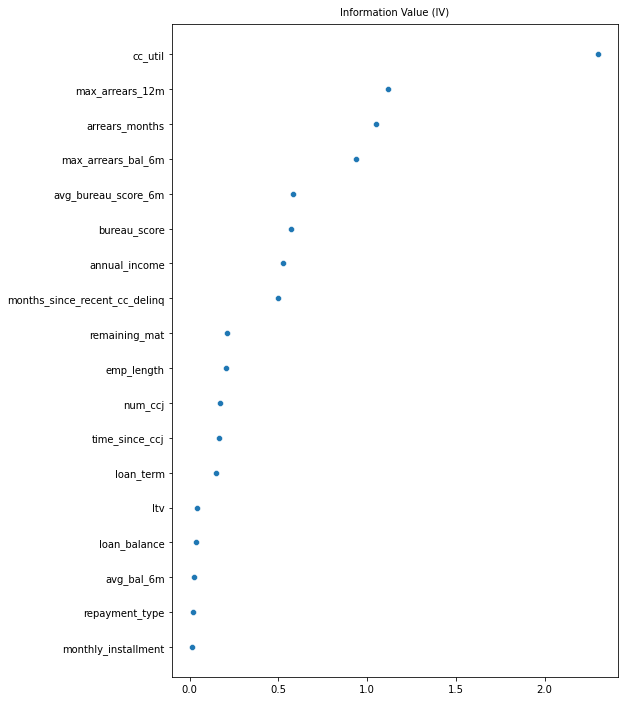

In [17]:
# Plot IV summary table
fig, ax = plt.subplots(figsize=(8,12))
#sns.scatterplot(data=iv_analysis, y="variable", x="info_value")
sns.scatterplot(data=IV, y="variable", x="total_iv")
plt.xlabel("Information Value (IV)", labelpad=10)
ax.xaxis.set_label_position('top')
plt.ylabel("")
plt.show()


#### Note

According to this Figure showing the Information value (IV), a part from 'cc_util', a set of 7 variables shows a strong 
power in predicting default (IV > 0.5). Other 6 variables have a medium IV, and 5 variables show weak discriminatory power
(IV < 0.1).
A business check highlights that some variables encompass similar information. In particular 'arrears_months' shares a similar content with 'max_arrears_12m' (that is, maximum number months in arrears during the last 12 months). Likewise, 'avg_bureau_score_6m' (that is, average bureau score over the previous 6-month period) is pretty close to 'bureau_score'. For this reason they are not considered in the next step of the process. As part of an expert judgement evaluation, 'emp_length' (that is, the length of employment), 'num_ccj' (number of County Court Judgements), and 'months_since_recent_cc_delinq' (number of months since the most recent delinquent status) are chosen among the variables with medium IV. All these variables constitute the long list to examine through a multivariate assessment


In [18]:
### Calculate weight of evidence (WOE) for target columns

### Multivariate analysis

##### Spearman rank correlation based on variables’ weight of evidence (WOE)

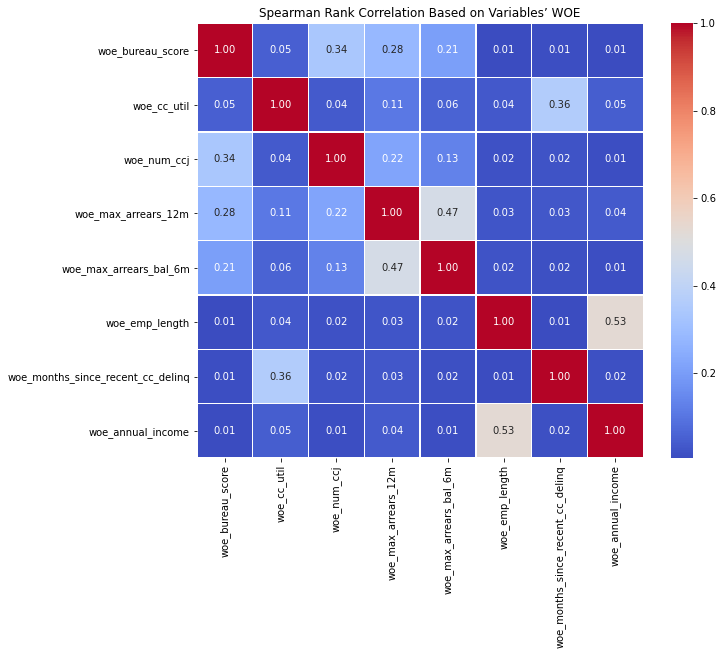

In [19]:
# Compute Spearman rank correlation based on variables’ weight of evidence (WOE)
# based on Table 2.2 binning scheme
woe_vars = woe_vars_train.filter(like="woe")
woe_corr = woe_vars.corr(method='spearman')

# Graphical inspection
plt.figure(figsize=(10, 8))
sns.heatmap(woe_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Rank Correlation Based on Variables’ WOE')
plt.show()


##### Stepwise regression

In [20]:
# Stepwise regression
# Discard highly correlated variable

# Select the concerned features (as noted above)
colswoe = ['woe_bureau_score', 'woe_cc_util', 'woe_max_arrears_12m', \
           'woe_months_since_recent_cc_delinq', 'woe_annual_income']
woe_vars_clean = woe_vars[colswoe]


# Stepwise model fitting
# Full data/featurea
logit_full = sm.GLM(train['default_event'], sm.add_constant(woe_vars),
                    family=sm.families.Binomial()).fit()

# Selected data/featurea
logit_stepwise = sm.GLM(train['default_event'], sm.add_constant(woe_vars_clean),
                        family=sm.families.Binomial()).fit()

#print(logit_full.summary())
print(logit_stepwise.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          default_event   No. Observations:                17825
Model:                            GLM   Df Residuals:                    17819
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2298.7
Date:                Mon, 15 Apr 2024   Deviance:                       4597.4
Time:                        19:11:11   Pearson chi2:                 1.71e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

### $ \bf \text{Calibration}$

In [21]:

# CALIBRATION
# Define a scaling function
def scaled_score(logit, odds, offset=500, pdo=20):
    '''
    scores scaling function
    '''
    b = pdo / np.log(2)
    a = offset - b * np.log(odds)
    
    return np.round(a + b * np.log((1 - logit) / logit))

# Score the entire dataset
# Use fitted model to score both test and train datasets
predict_logit_test = logit_stepwise.predict(sm.add_constant(woe_test_data[woe_vars_clean.columns]), transform=False)
predict_logit_train = logit_stepwise.predict(sm.add_constant(woe_train_data[woe_vars_clean.columns]), transform=False)

# Merge predictions with train/test data
woe_test_data.loc[:,'predict_logit'] = predict_logit_test
woe_train_data.loc[:,'predict_logit'] = predict_logit_train
woe_train_data.loc[:,'sample'] = 'train'
woe_test_data.loc[:,'sample'] = 'test'
data_whole = pd.concat([woe_train_data, woe_test_data])

# Define scoring parameters in line with objectives
data_whole.loc[:,'score'] = scaled_score(data_whole['predict_logit'], 72, 660, 40)
#data_whole.head(5)
data_whole[['score']]


,score
2876,745.0
25771,634.0
6507,453.0
4274,785.0
16262,579.0
...,...
8155,612.0
24624,489.0
11482,640.0
4161,565.0


In [22]:
# Upload data
data_score = data_whole.copy()  # Assuming data_whole is already defined

# Fit logistic regression
X = data_score[['score']]
y = data_score['default_event']
pd_model = sm.GLM(y, sm.add_constant(X), family=sm.families.Binomial()).fit()

# Print summary
print(pd_model.summary())

# Use model coefficients to obtain PDs
data_score['pd'] = pd_model.predict(sm.add_constant(X))


                 Generalized Linear Model Regression Results                  
Dep. Variable:          default_event   No. Observations:                25465
Model:                            GLM   Df Residuals:                    25463
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3256.6
Date:                Mon, 15 Apr 2024   Deviance:                       6513.2
Time:                        19:11:12   Pearson chi2:                 2.36e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3442      0.194     37.841      0.0

Training Gini coefficient = 0.6381317315510084


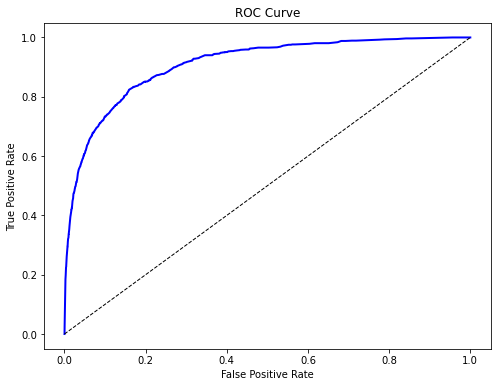

In [23]:
def gini_coefficient(y_true, y_pred):
    '''
    This fucntion returns the Gini coefficient 
    '''
    # Sort actual and predicted values by predicted values
    sorted_indices = np.argsort(y_pred)
    y_true_sorted = y_true.iloc[sorted_indices]
    n = len(y_true)
    
    # Compute the Gini coefficient
    cum_true = np.cumsum(y_true_sorted)
    sum_true = np.sum(y_true_sorted)
    gini_sum = np.sum((cum_true / sum_true) * (1 - cum_true / sum_true))
    
    return 1 - 2 * gini_sum / n


# Gini index
gini_train = gini_coefficient(woe_train_data['predict_logit'], woe_train_data['default_event'])
print('Training Gini coefficient = {}'.format(gini_train))
# 0.8335868

# ROC curve
fpr, tpr, thresholds = roc_curve(woe_train_data['default_event'], woe_train_data['predict_logit'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], '--', color='black', lw=1.)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Note:

The Gini coefficient is a measure of the inequality of a distribution, and it's often used in the context 
of binary classification models to measure their predictive power. In this case, a training Gini coefficient 
of 0.638 suggests that the model has a relatively high discriminatory power in separating the positive and 
negative classes in the training dataset.

A Gini coefficient closer to 1 indicates better discrimination, meaning the model is better at distinguishing 
between the positive and negative classes. In our case, a value of 0.638 suggests that the model is reasonably 
effective at this task. However, it could be essential to also evaluate the model on unseen data 
(e.g., a validation or test set) to ensure that it generalizes well beyond the training data.


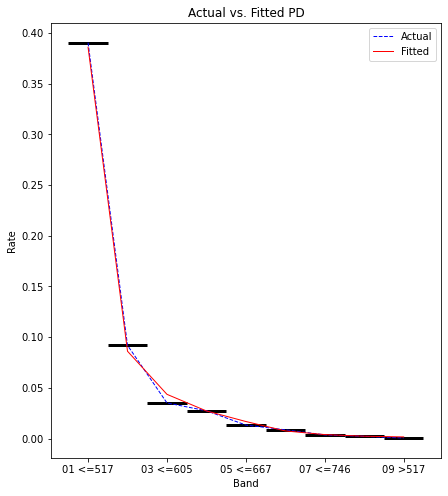

rmse = 0.0039574121735183355


In [29]:

# COMPARISON OF ACTUAL VERSUS FITTED PDS (BY SCORE BAND)

# Create score bands
cuts = [-np.inf, 517, 576, 605, 632, 667, 716, 746, 773, np.inf]
labels = ['01 <=517', '02 <=576', '03 <=605', '04 <=632', '05 <=667',\
          '06 <=716', '07 <=746', '09 <=773', '09 >517']

# Bin the 'score' variable based on the specified cuts
data_score['score_woe'] = pd.cut(data_score['score'], bins=cuts, labels=labels)

# Group by bands, and compare actual against fitted PDs
# Compute mean values
data_pd = data_score.groupby('score_woe').agg(mean_dr=('default_event', 'mean'), mean_pd=('pd', 'mean')).round(4).reset_index()

plt.figure(figsize=(7, 8))
plt.plot(data_pd['score_woe'], data_pd['mean_dr'], '--', color='blue', lw=1, label='Actual')

for band in range(len(data_pd)):
    plt.hlines(data_pd['mean_dr'][band], band-0.5, band+0.5, color='black', lw=3)

plt.plot(data_pd['score_woe'], data_pd['mean_pd'], '-',  color='red', lw=1, label='Fitted')
plt.xticks(['01 <=517',  '03 <=605', '05 <=667', '07 <=746', '09 >517'])
plt.title('Actual vs. Fitted PD')
plt.xlabel('Band')
plt.ylabel('Rate')
plt.legend()
plt.show()

# Compute rmse
rmse = np.sqrt(((data_pd['mean_dr'] - data_pd['mean_pd'])**2).mean())
print('rmse = {}'.format(rmse))
# 0.002732317


#### Note
The RMSE (Root Mean Square Error) is a measure of the differences between values predicted by a model and the actual
observed values. In the context of model evaluation, a lower RMSE indicates better accuracy of the model's predictions.

In this case, an RMSE of approximately 0.00396 suggests that the model's predictions are, on average, around 0.00396 units
away from the actual values. This indicates that the model's predictions are quite close to the actual values, indicating
good predictive performance.

In [ ]:

# Prepare the cross-validation dataset
data_subset = data_whole[['default_event', 'woe_bureau_score', 'woe_annual_income', \
                          'woe_max_arrears_12m', 'woe_months_since_recent_cc_delinq', \
                          'woe_cc_util']].copy()

# Perform the cross-validation loop
# Initialise loop arguments and vectors
m = 20  # number of folds
kf = KFold(n_splits=m)
auc_vector = np.zeros(m)
gini_vector = np.zeros(m)

# Run the loop
j = 0
for train_index, test_index in kf.split(data_subset):
    train_set, test_set = data_subset.iloc[train_index], data_subset.iloc[test_index]

    # Model Fitting
    X_train = train_set[['woe_bureau_score', 'woe_annual_income', 'woe_max_arrears_12m', \
                         'woe_months_since_recent_cc_delinq', 'woe_cc_util']]
    y_train = train_set['default_event']
    
    # Fit model with GLM
    model = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Binomial()).fit()

    # Predict results
    X_test = test_set[['woe_bureau_score', 'woe_annual_income', 'woe_max_arrears_12m',\
                       'woe_months_since_recent_cc_delinq', 'woe_cc_util']]
    predict_cv = model.predict(sm.add_constant(X_test))

    # Calculate performance metrics for each fold/run
    auc_vector[j] = roc_auc_score(test_set['default_event'], predict_cv)
    gini_vector[j] = 2 * auc_vector[j] - 1

    j += 1

# Print performance metrics
print("Mean AUC = ", np.mean(auc_vector))
print("Mean Gini = ", np.mean(gini_vector))


#### Note
After performing the cross-validation loop:

- The mean AUC of approximately 0.912 indicates that, on average, the model has very good discriminatory
power across different cross-validation folds. An AUC close to 1 suggests that the model is highly effective at 
distinguishing between the positive and negative classes.
- The mean Gini coefficient of approximately 0.825 suggests that the model's discriminatory power is also quite
high. The Gini coefficient is often considered a normalized version of the AUC, with values ranging from 0 to 1,
where higher values indicate better discrimination.

Overall, these results indicate that the model performs very well in terms of discrimination in the cross-validation 
process. However, keep in mind that it's important to validate the model's performance on unseen data to 
ensure that it generalizes well beyond the training dataset.

In [ ]:
# Plot / visualize AUC and Gini distributions
#fig, ax = plt.subplots(1,2, figsize=(18, 5))
#ax[0].hist(auc_vector, bins=7, color='blue', edgecolor='black')
#ax[0].set_xlabel('AUC distribution: {} folds'.format(m))
#ax[0].set_ylabel('Frequency')
#ax[1].hist(gini_vector, bins=7, color='purple', edgecolor='black')
#ax[1].set_xlabel('Gini distribution: {} folds'.format(m))
#ax[1].set_ylabel('Frequency')
#plt.show()
